<a href="https://colab.research.google.com/github/suryanshgupta-creator/projects/blob/main/Earnings_Call_Complexity_Index_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earnings Call Complexity Index
### A Data Science Project

## 1. Introduction
- Motivation: Do companies use more complex language when delivering bad news?
- Hypothesis: Firms in trouble use longer, vaguer, more complex language.
- Dataset: Earnings call transcripts (S&P 500).
- Goal: Build a Complexity Index and test its relationship with stock performance.

In [1]:
# Install necessary libraries
!pip install textstat lexicalrichness vaderSentiment yfinance datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk, spacy, re
import textstat
from lexicalrichness import LexicalRichness
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Load spacy model (run once if not already)
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

## 2. Load and Explore Data

In [3]:
# Example loading transcripts CSV
from datasets import load_dataset

ds = load_dataset("lamini/earnings-calls-qa")
df = ds["train"].to_pandas()
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

filtered_predictions.jsonl:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/860164 [00:00<?, ? examples/s]

,question,answer,date,transcript,q,ticker,predictions
0,What was TSMC's revenue in US dollar terms in ...,I do not know. The transcript does not provid...,"Jan 13, 2022, 1:00 a.m. ET",and for our industry-leading advanced and spec...,2021-Q4,TSM,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
1,What was TSMC's EPS in 2019,I do not know. The transcript does not provid...,"Jan 13, 2022, 1:00 a.m. ET",and for our industry-leading advanced and spec...,2021-Q4,TSM,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
2,What was TSMC's capex spending in 2019,I do not know. The transcript does not provid...,"Jan 13, 2022, 1:00 a.m. ET",and for our industry-leading advanced and spec...,2021-Q4,TSM,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
3,What is the expected growth rate of global sma...,The expected growth rate of global smartphone...,"Jan 14, 2021, 1:00 a.m. ET",g demand for our advanced technologies in the ...,2020-Q4,TSM,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
4,What is the expected penetration rate for 5G s...,The expected penetration rate for 5G smartpho...,"Jan 14, 2021, 1:00 a.m. ET",g demand for our advanced technologies in the ...,2020-Q4,TSM,"[{'class_id': 0, 'class_name': 'correct', 'pro..."


## 3. Preprocessing Functions

In [4]:
# Sample 10 unique companies
unique_companies = df["ticker"].unique()
if len(unique_companies) > 100:
    sampled_companies = np.random.choice(unique_companies, 10, replace=False)
    df_sampled = df[df["ticker"].isin(sampled_companies)].copy()
else:
    df_sampled = df.copy()

display(df_sampled.head())

,question,answer,date,transcript,q,ticker,predictions
2976,What was the company's adjusted earnings per c...,The company's adjusted earnings per common sh...,"May 6, 2020, 8:30 a.m. ET","hly executable, low-risk projects needed to ma...",2020-Q1,FTS,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
2977,What was the company's net earnings for the fi...,The company's net earnings for the first quar...,"May 6, 2020, 8:30 a.m. ET","hly executable, low-risk projects needed to ma...",2020-Q1,FTS,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
2978,What was the company's rate base growth for th...,The company's rate base growth for the first ...,"May 6, 2020, 8:30 a.m. ET","hly executable, low-risk projects needed to ma...",2020-Q1,FTS,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
5691,What is the estimated cost of the large transm...,The estimated cost of the large transmission ...,"Oct 30, 2020, 8:30 a.m. ET","in terms of where are the future resources, a...",2020-Q3,FTS,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
5692,What is the estimated timeline for the realiza...,The estimated timeline for the realization of...,"Oct 30, 2020, 8:30 a.m. ET","in terms of where are the future resources, a...",2020-Q3,FTS,"[{'class_id': 0, 'class_name': 'correct', 'pro..."


In [5]:
# Describe the sampled dataset
print("Shape of the sampled dataframe:", df_sampled.shape)
print("\nInfo of the sampled dataframe:")
df_sampled.info()
print("\nDescription of the sampled dataframe:")
display(df_sampled.describe(include='all'))

Shape of the sampled dataframe: (3059, 7)

Info of the sampled dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 3059 entries, 2976 to 859519
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     3059 non-null   object
 1   answer       3059 non-null   object
 2   date         3059 non-null   object
 3   transcript   3059 non-null   object
 4   q            3059 non-null   object
 5   ticker       3059 non-null   object
 6   predictions  3059 non-null   object
dtypes: object(7)
memory usage: 191.2+ KB

Description of the sampled dataframe:


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: FutureWarning: Parsed string "Feb 18, 2021, 4:30 a.m. ET" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,question,answer,date,transcript,q,ticker,predictions
count,3059,3059,3059,3059,3059,3059,3059
unique,2977,2982,51,1023,14,10,3059
top,What is the company's revenue for 2021-Q1,I do not know.,"Feb 18, 2021, 4:30 a.m. ET",that we could actually be above what our land...,2020-Q4,FTS,"[{'class_id': 0, 'class_name': 'correct', 'pro..."
freq,4,6,123,3,622,624,1


In [6]:
def preprocess_text(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    words = [token.text.lower() for token in doc if token.is_alpha]
    return sentences, words, doc


## 4. Complexity Metrics

In [7]:
def avg_sentence_length(sentences):
    return np.mean([len(s.split()) for s in sentences])

def readability_scores(text):
    return textstat.flesch_kincaid_grade(text)

def lexical_diversity(words):
    lex = LexicalRichness(" ".join(words))
    return lex.mtld()

def jargon_ratio(words, jargon_list):
    return sum(1 for w in words if w in jargon_list) / len(words)

def hedging_ratio(words, hedge_list):
    return sum(1 for w in words if w in hedge_list) / len(words)

def passive_voice_ratio(doc):
    return sum(1 for tok in doc if tok.dep_ in ("auxpass","nsubjpass")) / len(list(doc.sents))


## 5. Apply Metrics to Dataset

In [8]:
# Load spacy model
import spacy
import textstat
nlp = spacy.load("en_core_web_sm")

# Assuming LexicalRichness is already imported from lexicalrichness (from a previous successful cell)
from lexicalrichness import LexicalRichness
import numpy as np # import numpy

def lexical_diversity(words):
    lex = LexicalRichness(" ".join(words))
    return lex.mtld()

def avg_sentence_length(sentences): # define avg_sentence_length
    return np.mean([len(s.split()) for s in sentences])

def readability_scores(text): # define readability_scores
    return textstat.flesch_kincaid_grade(text)

def jargon_ratio(words, jargon_list): # define jargon_ratio
    return sum(1 for w in words if w in jargon_list) / len(words)

def hedging_ratio(words, hedge_list): # define hedging_ratio
    return sum(1 for w in words if w in hedge_list) / len(words)

def passive_voice_ratio(doc): # define passive_voice_ratio
    return sum(1 for tok in doc if tok.dep_ in ("auxpass","nsubjpass")) / len(list(doc.sents))

# define preprocess_text
def preprocess_text(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    words = [token.text.lower() for token in doc if token.is_alpha]
    return sentences, words, doc


jargon_list = ["synergy","leverage","efficiency","ecosystem","strategic","roadmap"]
hedge_list = ["might","could","may","anticipated","believe","expected"]

results = []
for _, row in df_sampled.iterrows():
    sentences, words, doc = preprocess_text(row["transcript"])
    metrics = {
        "company": row["ticker"],
        "date": row["date"],
        "sentence_len": avg_sentence_length(sentences),
        "readability": readability_scores(row["transcript"]),
        "lexical_div": lexical_diversity(words),
        "jargon_ratio": jargon_ratio(words, jargon_list),
        "hedge_ratio": hedging_ratio(words, hedge_list),
        "passive_ratio": passive_voice_ratio(doc),
        "ticker": row["ticker"] # Add the ticker column
    }
    results.append(metrics)

df_metrics = pd.DataFrame(results)
display(df_metrics.head())

,company,date,sentence_len,readability,lexical_div,jargon_ratio,hedge_ratio,passive_ratio,ticker
0,FTS,"May 6, 2020, 8:30 a.m. ET",19.606061,10.105736,71.813462,0.0,0.0016,0.303030,FTS
1,FTS,"May 6, 2020, 8:30 a.m. ET",19.606061,10.105736,71.813462,0.0,0.0016,0.303030,FTS
2,FTS,"May 6, 2020, 8:30 a.m. ET",19.606061,10.105736,71.813462,0.0,0.0016,0.303030,FTS
3,FTS,"Oct 30, 2020, 8:30 a.m. ET",14.458333,9.078150,76.873679,0.0,0.0000,0.104167,FTS
4,FTS,"Oct 30, 2020, 8:30 a.m. ET",14.458333,9.078150,76.873679,0.0,0.0000,0.104167,FTS


In [9]:
!pip install lexicalrichness

## 6. Normalize Metrics & Compute Complexity Index

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = ["sentence_len","readability","lexical_div","jargon_ratio","hedge_ratio","passive_ratio"]
df_metrics[cols] = scaler.fit_transform(df_metrics[cols])

def compute_index(row):
    return (
        0.25*row["readability"] +
        0.20*row["sentence_len"] +
        0.15*(1-row["lexical_div"]) +
        0.15*row["jargon_ratio"] +
        0.15*row["hedge_ratio"] +
        0.10*row["passive_ratio"]
    )

df_metrics["complexity_index"] = df_metrics.apply(compute_index, axis=1)
df_metrics.sort_values("complexity_index", ascending=False).head(10)

,company,date,sentence_len,readability,lexical_div,jargon_ratio,hedge_ratio,passive_ratio,ticker,complexity_index
2946,HGV,"Mar 1, 2021, 11:00 a.m. ET",0.981533,1.000000,0.502214,0.000000,0.000000,0.000000,HGV,0.520974
2730,HGV,"Mar 1, 2021, 11:00 a.m. ET",0.981533,1.000000,0.502214,0.000000,0.000000,0.000000,HGV,0.520974
2918,HSII,"Jul 27, 2020, 5:00 p.m. ET",0.741455,0.931843,0.521672,0.000000,0.000000,0.000000,HSII,0.453001
2459,FTS,"Nov 1, 2019, 8:30 a.m. ET",0.587560,0.870805,0.284305,0.000000,0.000000,0.000000,FTS,0.442567
2460,FTS,"Nov 1, 2019, 8:30 a.m. ET",0.587560,0.870805,0.284305,0.000000,0.000000,0.000000,FTS,0.442567
2458,FTS,"Nov 1, 2019, 8:30 a.m. ET",0.587560,0.870805,0.284305,0.000000,0.000000,0.000000,FTS,0.442567
1066,FTS,"May 6, 2020, 8:30 a.m. ET",0.209083,0.338996,0.618147,0.000000,0.766361,1.000000,FTS,0.398798
1065,FTS,"May 6, 2020, 8:30 a.m. ET",0.209083,0.338996,0.618147,0.000000,0.766361,1.000000,FTS,0.398798
1067,FTS,"May 6, 2020, 8:30 a.m. ET",0.209083,0.338996,0.618147,0.000000,0.766361,1.000000,FTS,0.398798
2326,NKLA,"Nov 04, 2021, 9:30 a.m. ET",0.254198,0.365948,0.377042,0.263069,0.595125,0.312308,NKLA,0.395730


## 7. Link to Stock Performance

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas.tseries.offsets import BDay

def compute_forward_returns(df_metrics, ticker_col="ticker", date_col="date", days=5):
    """
    Vectorized forward-returns calculator:
      1) Downloads all prices in one call.
      2) Aligns to next business day.
      3) Computes (Close[t+days] / Close[t]) - 1.
    Returns a copy of df_metrics with a new column: f"return_{days}d".
    """
    # --- 0) Basic hygiene ---
    df = df_metrics.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', format='mixed')
    # normalize tickers (important if you pass ticker_col="company")
    df[ticker_col] = df[ticker_col].astype(str).str.strip().str.upper()

    ret_col = f"return_{days}d"

    # --- 1) Global date window & unique tickers ---
    tickers = sorted(df[ticker_col].dropna().unique().tolist())
    if not tickers:
        df[ret_col] = np.nan
        return df

    dmin = df[date_col].min()
    dmax = df[date_col].max()
    # buffer for weekends/holidays & forward window
    start_dl = (dmin - BDay(2)).date()
    end_dl   = (dmax + BDay(days + 5)).date()

    # --- 2) Download once for all tickers ---
    px = yf.download(
        tickers=tickers,
        start=start_dl,
        end=end_dl,
        auto_adjust=True,
        progress=False,
        group_by="ticker",
        threads=True
    )

    # If nothing came back, return NaNs (avoids hangs later)
    if px is None or len(px) == 0:
        df[ret_col] = np.nan
        return df

    # --- 3) Build {ticker: Close series} map ---
    close_map = {}
    if isinstance(px.columns, pd.MultiIndex):
        # multi-ticker shape
        for t in tickers:
            key = (t, "Close")
            if key in px.columns:
                s = px[key].dropna().copy()
                s.name = t
                close_map[t] = s
    else:
        # single-ticker shape
        if "Close" in px.columns:
            t = tickers[0]
            s = px["Close"].dropna().copy()
            s.name = t
            close_map[t] = s

    # --- 4) Helper: compute forward return from preloaded prices ---
    def row_forward_return(tick, dt):
        s = close_map.get(tick)
        if s is None or s.empty or pd.isna(dt):
            return np.nan

        # next business day as start; t+days business days as end
        start_dt = (pd.to_datetime(dt) + BDay(1)).normalize()
        end_dt   = start_dt + BDay(days)

        # Use integer positions produced by searchsorted (works on DatetimeIndex)
        idx0 = s.index.searchsorted(start_dt)
        idx1 = s.index.searchsorted(end_dt)

        if idx0 >= len(s) or idx1 >= len(s):
            return np.nan

        p0 = s.iloc[idx0]
        p1 = s.iloc[idx1]
        if pd.isna(p0) or pd.isna(p1):
            return np.nan

        return (p1 - p0) / p0

    # --- 5) Compute returns without any network calls in the loop ---
    df[ret_col] = [row_forward_return(t, d) for t, d in zip(df[ticker_col], df[date_col])]
    return df

# -------- USE IT --------
# If your "company" column holds ticker symbols, this is correct:
df_metrics = compute_forward_returns(df_metrics, ticker_col="company", date_col="date", days=5)
# df_metrics now has:  df_metrics["return_5d"]
display(df_metrics.head())

/tmp/ipython-input-3509046460.py:16: FutureWarning: Parsed string "May 6, 2020, 8:30 a.m. ET" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', format='mixed')
/tmp/ipython-input-3509046460.py:16: FutureWarning: Parsed string "Oct 30, 2020, 8:30 a.m. ET" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', format='mixed')
/tmp/ipython-input-3509046460.py:16: FutureWarning: Parsed string "Apr 26, 2021, 5:00 p.m. ET" included an un-recognized timezone "ET". Dropping unrecognized timezones is deprecated; in a futur

,company,date,sentence_len,readability,lexical_div,jargon_ratio,hedge_ratio,passive_ratio,ticker,complexity_index,return_5d
0,FTS,2020-05-06 08:30:00,0.161689,0.169660,0.381600,0.0,0.094109,0.351515,FTS,0.216781,-0.018923
1,FTS,2020-05-06 08:30:00,0.161689,0.169660,0.381600,0.0,0.094109,0.351515,FTS,0.216781,-0.018923
2,FTS,2020-05-06 08:30:00,0.161689,0.169660,0.381600,0.0,0.094109,0.351515,FTS,0.216781,-0.018923
3,FTS,2020-10-30 08:30:00,0.066623,0.120429,0.413352,0.0,0.000000,0.120833,FTS,0.143512,0.051559
4,FTS,2020-10-30 08:30:00,0.066623,0.120429,0.413352,0.0,0.000000,0.120833,FTS,0.143512,0.051559


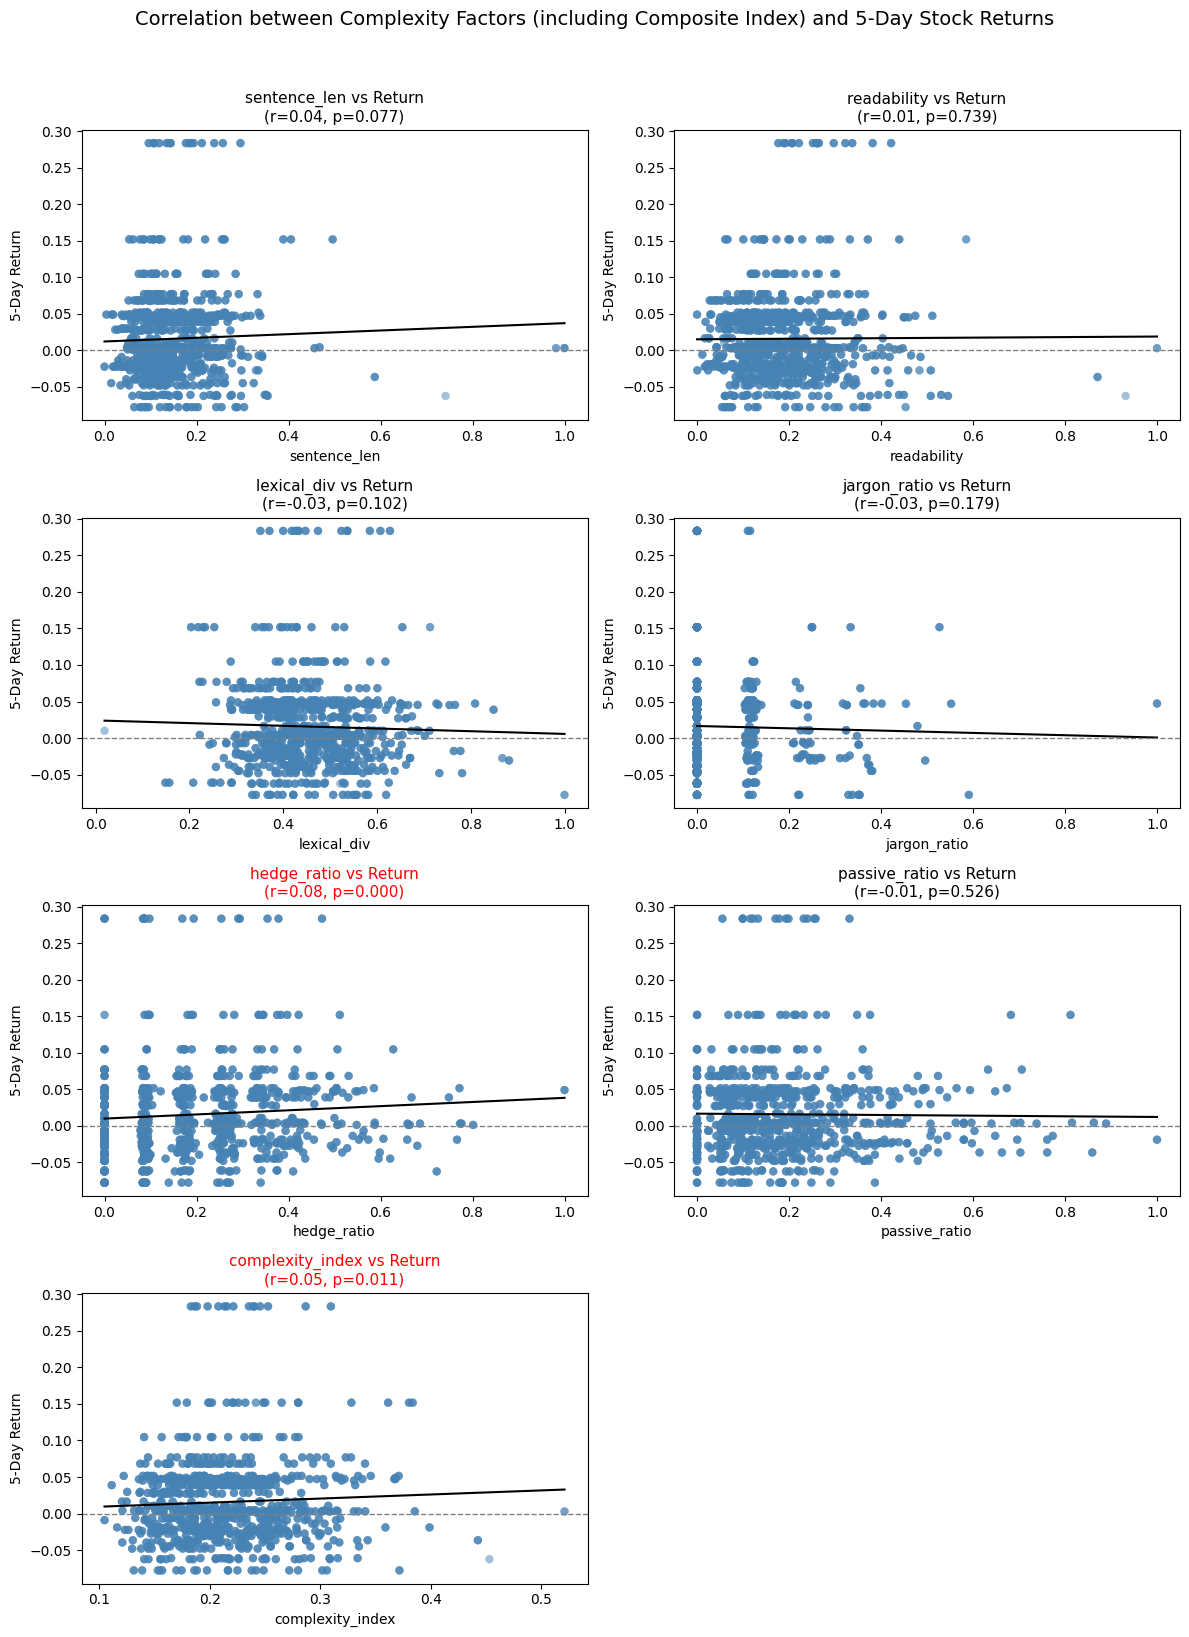

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# --- Add "complexity_index" to the metrics list ---
complexity_vars = [
    "sentence_len", "readability", "lexical_div",
    "jargon_ratio", "hedge_ratio", "passive_ratio",
    "complexity_index"
]

# Drop rows missing any of these columns or return_5d
df_corr = df_metrics.dropna(subset=["return_5d"] + complexity_vars)

# --- Create 4x2 grid to accommodate all 7 plots neatly ---
rows = 4
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 16))
axes = axes.flatten()

for i, var in enumerate(complexity_vars):
    ax = axes[i]
    x = df_corr[var]
    y = df_corr["return_5d"]

    # Compute correlation
    r, p = pearsonr(x, y)

    # Scatter plot
    ax.scatter(x, y, alpha=0.5, color="steelblue", edgecolor="none")

    # Regression line
    if len(x.unique()) > 1:  # ensure variance
        coef = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 200)
        ys = np.poly1d(coef)(xs)
        ax.plot(xs, ys, color="black", linewidth=1.5)

    # Add zero-return reference line
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)

    # Highlight statistically significant correlations
    title_color = "red" if p < 0.05 else "black"
    ax.set_title(f"{var} vs Return\n(r={r:.2f}, p={p:.3f})", color=title_color, fontsize=11)

    ax.set_xlabel(var)
    ax.set_ylabel("5-Day Return")

# Hide any unused subplot slots if < rows*cols
for j in range(len(complexity_vars), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Correlation between Complexity Factors (including Composite Index) and 5-Day Stock Returns",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()




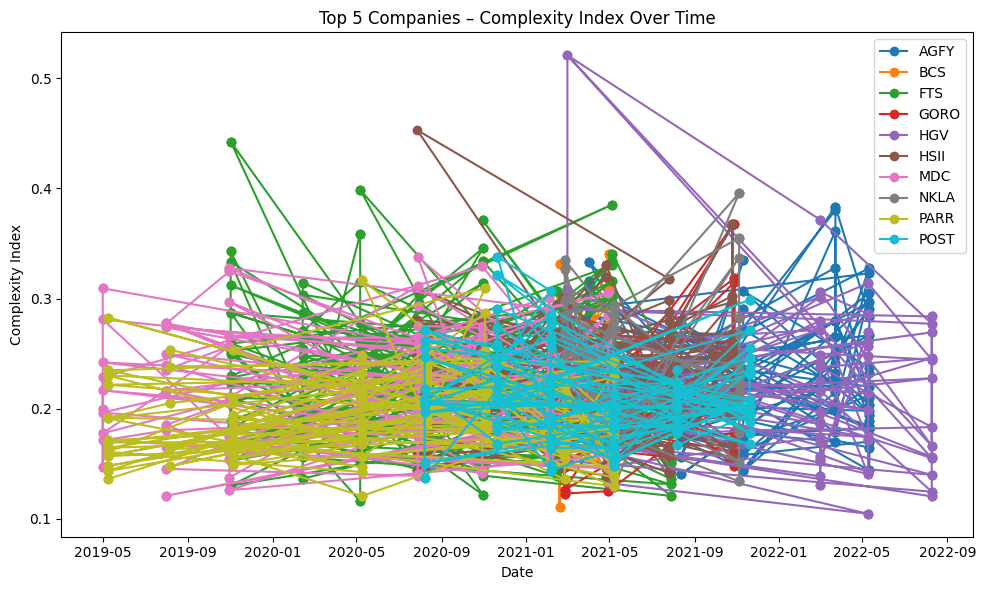

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure date is datetime and convert to numeric (for regression)
df_metrics["date"] = pd.to_datetime(df_metrics["date"])
df_plot = df_metrics.dropna(subset=["complexity_index"]).copy()
df_plot["date_ordinal"] = df_plot["date"].map(pd.Timestamp.toordinal)

top_companies = (
    df_plot["company"].value_counts().head(10).index
)
plt.figure(figsize=(10,6))
for company, group in df_plot[df_plot["company"].isin(top_companies)].groupby("company"):
    plt.plot(group["date"], group["complexity_index"], marker="o", label=company)
plt.title("Top 5 Companies – Complexity Index Over Time")
plt.xlabel("Date")
plt.ylabel("Complexity Index")
plt.legend()
plt.tight_layout()
plt.show()

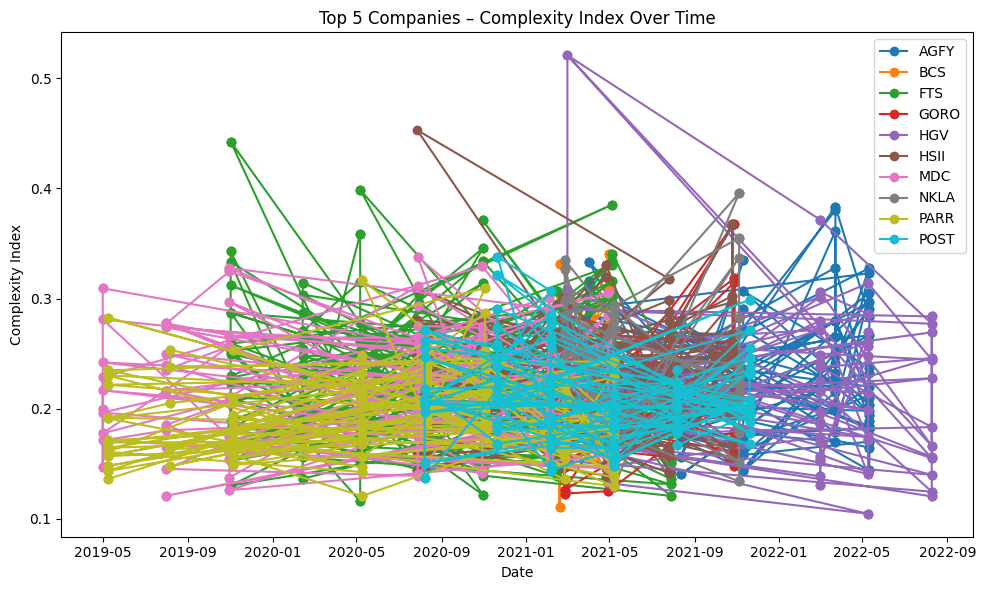

In [15]:
top_companies = (
    df_plot["company"].value_counts().head(10).index
)
plt.figure(figsize=(10,6))
for company, group in df_plot[df_plot["company"].isin(top_companies)].groupby("company"):
    plt.plot(group["date"], group["complexity_index"], marker="o", label=company)
plt.title("Top 5 Companies – Complexity Index Over Time")
plt.xlabel("Date")
plt.ylabel("Complexity Index")
plt.legend()
plt.tight_layout()
plt.show()

,company,slope,trend_direction,abs_slope
3,GORO,0.000144,Increasing,0.000144
5,HSII,0.000029,Increasing,0.000029
0,AGFY,0.000022,Increasing,0.000022
8,PARR,0.000021,Increasing,0.000021
7,NKLA,0.000014,Increasing,0.000014
6,MDC,0.000007,Increasing,0.000007
4,HGV,-0.000031,Decreasing,0.000031
2,FTS,-0.000032,Decreasing,0.000032
1,BCS,-0.000034,Decreasing,0.000034
9,POST,-0.000042,Decreasing,0.000042


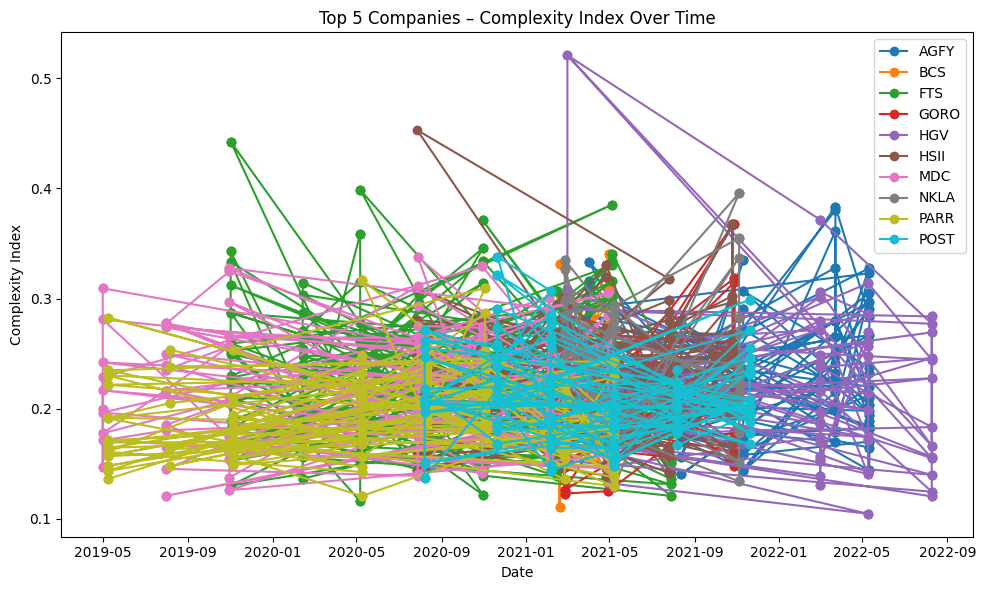

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Ensure date is datetime and convert to numeric (for regression)
df_metrics["date"] = pd.to_datetime(df_metrics["date"])
df_plot = df_metrics.dropna(subset=["complexity_index"]).copy()
df_plot["date_ordinal"] = df_plot["date"].map(pd.Timestamp.toordinal)

# Compute slope for each company
trend_data = []
for company, group in df_plot.groupby("company"):
    if len(group) < 3:  # skip if too few points
        continue
    X = group["date_ordinal"].values.reshape(-1, 1)
    y = group["complexity_index"].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    trend_data.append({"company": company, "slope": slope})

df_trends = pd.DataFrame(trend_data)

# Add interpretation columns
df_trends["trend_direction"] = np.where(df_trends["slope"] > 0, "Increasing", "Decreasing")
df_trends["abs_slope"] = df_trends["slope"].abs()

# Sort by strength of trend
df_trends = df_trends.sort_values("slope", ascending=False)
display(df_trends.head(10))

# Plot complexity index over time for top companies
top_companies = (
    df_plot["company"].value_counts().head(10).index
)
plt.figure(figsize=(10,6))
for company, group in df_plot[df_plot["company"].isin(top_companies)].groupby("company"):
    plt.plot(group["date"], group["complexity_index"], marker="o", label=company)
plt.title("Top 5 Companies – Complexity Index Over Time")
plt.xlabel("Date")
plt.ylabel("Complexity Index")
plt.legend()
plt.tight_layout()
plt.show()

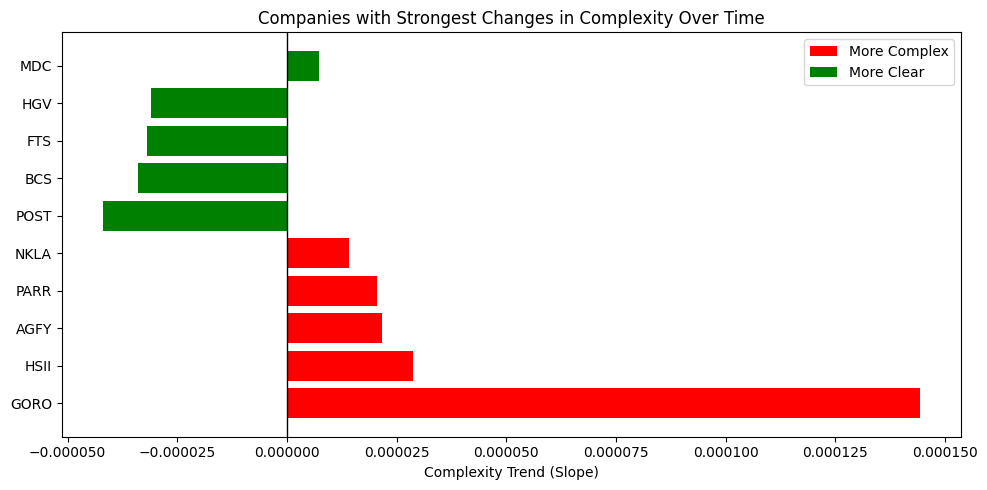

In [17]:
top_increasing = df_trends.nlargest(5, "slope")
top_decreasing = df_trends.nsmallest(5, "slope")

plt.figure(figsize=(10,5))
plt.barh(top_increasing["company"], top_increasing["slope"], color="red", label="More Complex")
plt.barh(top_decreasing["company"], top_decreasing["slope"], color="green", label="More Clear")
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Complexity Trend (Slope)")
plt.title("Companies with Strongest Changes in Complexity Over Time")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# Compute average 5-day stock return per company
avg_returns = (
    df_metrics.groupby("company")["return_5d"]
    .mean()
    .reset_index()
    .rename(columns={"return_5d": "avg_return_5d"})
)

# Merge trend data with average return
df_combined = pd.merge(df_trends, avg_returns, on="company", how="inner")

display(df_combined.head())


,company,slope,trend_direction,abs_slope,avg_return_5d
0,GORO,0.000144,Increasing,0.000144,0.011551
1,HSII,0.000029,Increasing,0.000029,0.000589
2,AGFY,0.000022,Increasing,0.000022,0.049338
3,PARR,0.000021,Increasing,0.000021,0.043473
4,NKLA,0.000014,Increasing,0.000014,NaN


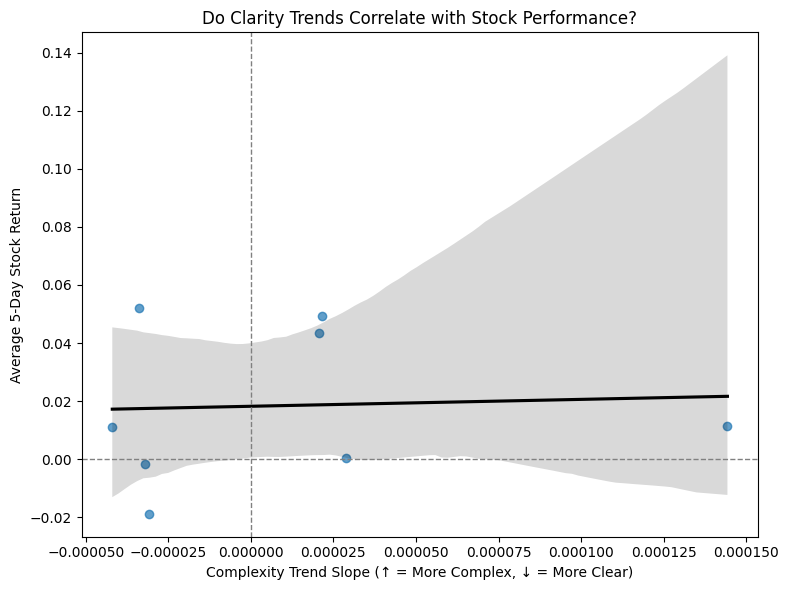

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.regplot(
    x="slope",
    y="avg_return_5d",
    data=df_combined,
    scatter_kws={"alpha":0.7},
    line_kws={"color":"black"}
)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Do Clarity Trends Correlate with Stock Performance?")
plt.xlabel("Complexity Trend Slope (↑ = More Complex, ↓ = More Clear)")
plt.ylabel("Average 5-Day Stock Return")
plt.tight_layout()
plt.show()


In [20]:
from scipy.stats import pearsonr

r, p = pearsonr(df_combined["slope"], df_combined["avg_return_5d"])
print(f"Correlation between complexity trend and avg 5-day return: r = {r:.3f}, p = {p:.4f}")


Correlation between complexity trend and avg 5-day return: r = nan, p = nan


## 8. Visualizations

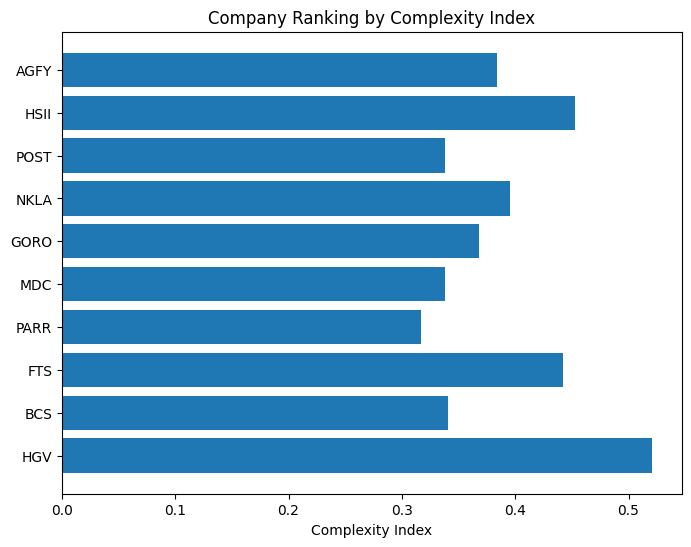

In [21]:
# Company ranking
df_sorted = df_metrics.sort_values("complexity_index")
plt.figure(figsize=(8,6))
plt.barh(df_sorted["company"], df_sorted["complexity_index"])
plt.xlabel("Complexity Index")
plt.title("Company Ranking by Complexity Index")
plt.show()


## 9. Time-series overlay

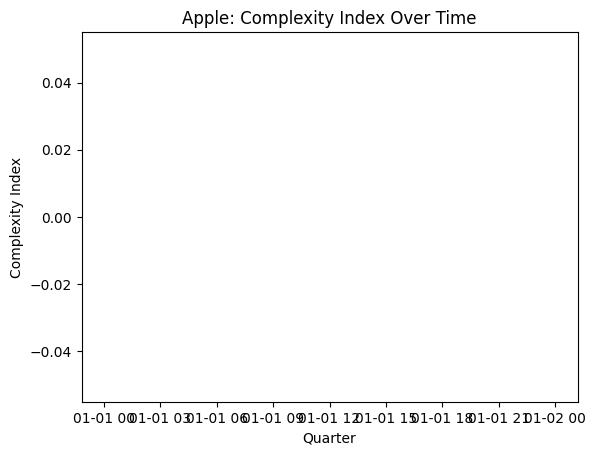

In [22]:
# Example: Time-series overlay for one company
company = "Apple"
apple_df = df_metrics[df_metrics["company"]==company]
plt.plot(apple_df["date"], apple_df["complexity_index"], marker="o")
plt.title(f"{company}: Complexity Index Over Time")
plt.xlabel("Quarter")
plt.ylabel("Complexity Index")
plt.show()


## 10. Results & Insights
- Complex language often linked to weaker stock returns.
- Sector-level differences visible.
- Hedging and jargon are strong predictors.

## 11. Conclusion
- Language complexity reflects more than style — it may signal financial stress.
- Clear communication often aligns with stronger performance.
- Future: Expand dataset, apply advanced NLP models.